In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize

import string, warnings, urllib3, locale

warnings.filterwarnings('ignore')
locale.setlocale(locale.LC_ALL, 'es_ES.UTF-8')

'es_ES.UTF-8'

In [2]:
Punct_List = dict((ord(punct), None) for punct in string.punctuation + '¿¡')

def TxNormalize(text):
    
    return word_tokenize(text.lower().translate(Punct_List))

def respuesta(texto):
    Tokens_List.append(texto)
    TfidfVec = TfidfVectorizer(tokenizer = TxNormalize) 
    tfidf = TfidfVec.fit_transform(Tokens_List)
    Tokens_List.remove(texto)
    vals = cosine_similarity(tfidf[-1], tfidf)
    flat = vals.flatten()
    flat.sort()
    
    return Tokens_List[vals.argsort()[0][-2]]

def nice_axes(ax):
    plt.legend(loc = 'upper center'
               , bbox_to_anchor = (0.5, 1.1)
               , ncol = len(df.columns)
               , fancybox = False
               , shadow = True
               , fontsize = 20)

    [spine.set_visible(False) for spine in ax.spines.values()]

    ax.set_yticklabels([int(x) if x > 0 else '' for x in ax.get_yticks()])

    vals = ax.get_xticks()
    ax.tick_params(left = False, bottom = False)
    ax.grid(axis='y', alpha=0.25)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.set_xlabel('')

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))

In [3]:
url = 'https://es.wikipedia.org/wiki/ISO_3166-2:ES'
comunidades = {}

urllib3.disable_warnings()
http = urllib3.PoolManager()
response = http.request('GET', url)
soup = BeautifulSoup(response.data, 'html.parser')

for i in soup.find_all('tr'):
    if len(i.find_all('td')) == 2:
        k = str(i.find_all('td')[1].find_all('a')[0])
        comunidades[str(i.find_all('td')[0])[11:13]] = k[k.find('title') + 7:k.find('">')]

comunidades 

{'AN': 'Andalucía',
 'AR': 'Aragón',
 'AS': 'Asturias',
 'CN': 'Canarias',
 'CB': 'Cantabria',
 'CM': 'Castilla-La Mancha',
 'CL': 'Castilla y León',
 'CT': 'Cataluña',
 'EX': 'Extremadura',
 'GA': 'Galicia',
 'IB': 'Islas Baleares',
 'RI': 'La Rioja (España)',
 'MD': 'Comunidad de Madrid',
 'MC': 'Región de Murcia',
 'NC': 'Comunidad Foral de Navarra',
 'PV': 'País Vasco',
 'VC': 'Comunidad Valenciana',
 'CE': 'Ceuta',
 'ML': 'Melilla'}

## Poblacion

In [4]:
url = 'https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/2853.csv?nocab=1'

poblacion = pd.read_csv(url, error_bad_lines=False, sep=';', header=0)

poblacion = poblacion[(poblacion['Comunidades y Ciudades Autónomas'] != 'Total') 
                      & (poblacion['Periodo'] == 2020)].pivot(index = 'Comunidades y Ciudades Autónomas'
                                                             , columns = 'Sexo'
                                                             , values = 'Total')

Tokens_List = sent_tokenize(" ".join(review + '.' for review in comunidades.values()), 'spanish')
matriz = {}

for i in poblacion.index.values:
    matriz[i] = respuesta(i.replace('Balears','Baleares'))[:-1]
            
poblacion.index = poblacion.index.map(matriz)

poblacion.Total = poblacion.Total.str.replace('.','').astype(int)

poblacion = poblacion.Total

poblacion

Comunidades y Ciudades Autónomas
Andalucía                     8464411
Aragón                        1329391
Asturias                      1018784
Islas Baleares                1171543
Canarias                      2175952
Cantabria                      582905
Castilla y León               2394918
Castilla-La Mancha            2045221
Cataluña                      7780479
Comunidad Valenciana          5057353
Extremadura                   1063987
Galicia                       2701819
Comunidad de Madrid           6779888
Región de Murcia              1511251
Comunidad Foral de Navarra     661197
País Vasco                    2220504
La Rioja (España)              319914
Ceuta                           84202
Melilla                         87076
Name: Total, dtype: int64

In [5]:
url = 'https://cnecovid.isciii.es/covid19/resources/casos_tecnica_ccaa.csv'
df = pd.read_csv(url)

df = (df
      .assign(ccaa_iso = df.ccaa_iso.map(comunidades))
      .set_index('ccaa_iso')
      .merge(poblacion, left_index=True, right_index=True)
      .reset_index()
      .set_index('fecha')
      .rename(columns = {'index': 'Comunidad'
                         , 'num_casos': 'Casos'
                        }))

df[df.Comunidad == 'Comunidad Valenciana'].tail(15)['Casos']

fecha
2021-02-18    387
2021-02-19    402
2021-02-20    366
2021-02-21    216
2021-02-22    295
2021-02-23    346
2021-02-24    271
2021-02-25    266
2021-02-26    242
2021-02-27    125
2021-02-28     87
2021-03-01    105
2021-03-02     86
2021-03-03     86
2021-03-04      0
Name: Casos, dtype: int64

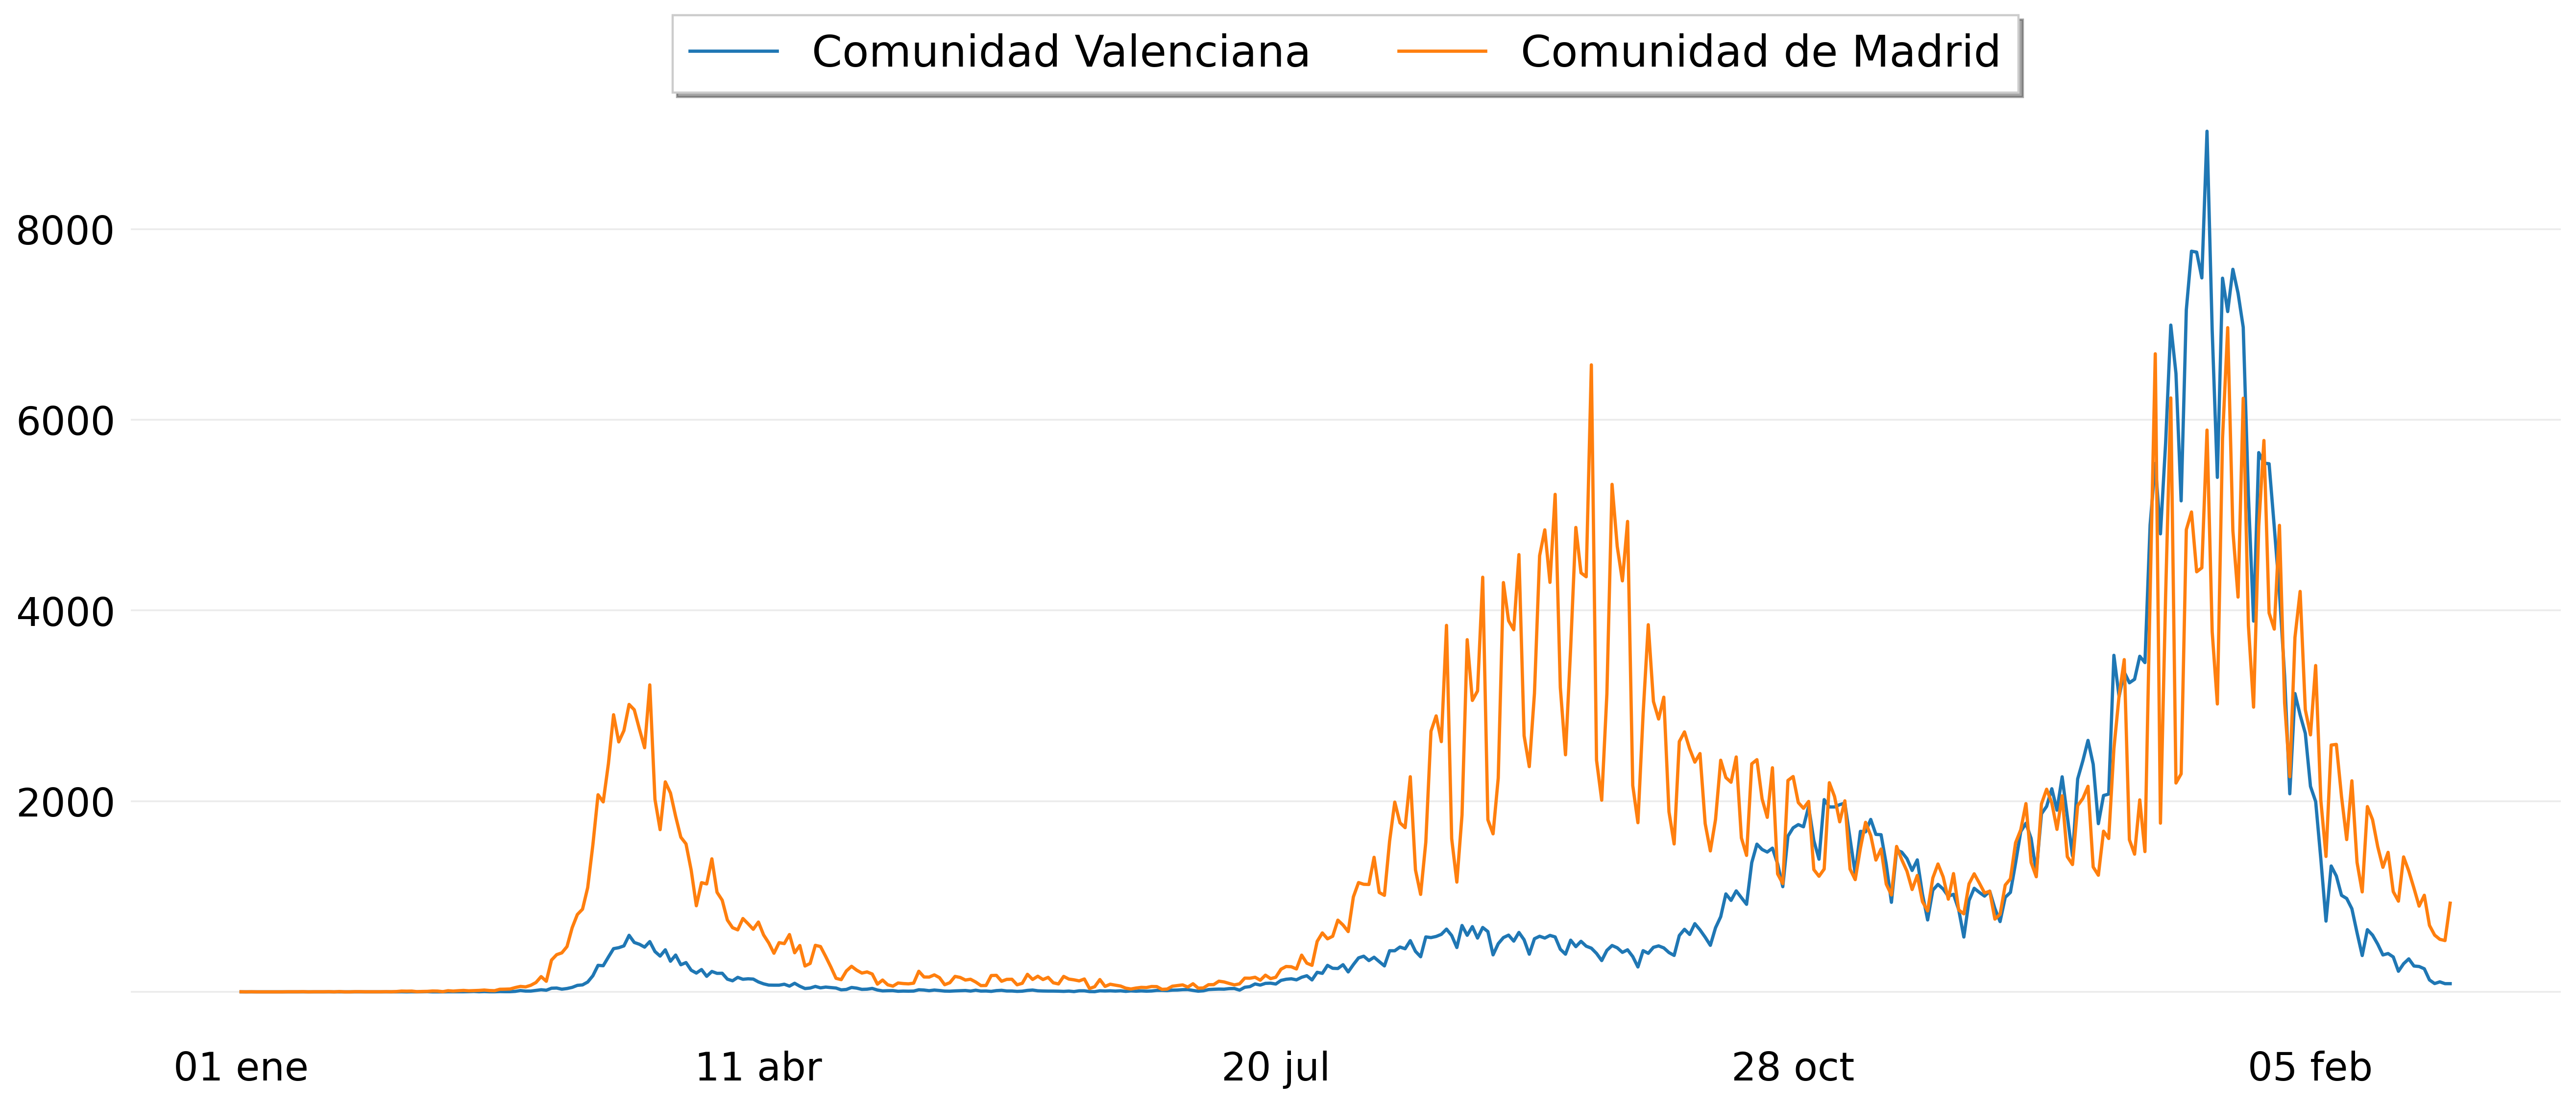

In [6]:
fig, ax = plt.subplots(figsize=(20,8)
                       , dpi = 320)

series = ['Comunidad Valenciana', 'Comunidad de Madrid']
for i in series:
    df[df.Comunidad == i][:-1]['Casos'].plot(label = i)

nice_axes(ax)
plt.show()

In [7]:
df['Incidencia'] = df.Casos / df.Total * 1e5

df = df.pivot(columns='Comunidad', values = 'Incidencia')

df2 = df \
        + df.shift(1) \
        + df.shift(2) \
        + df.shift(3) \
        + df.shift(4) \
        + df.shift(5) \
        + df.shift(6) \
        + df.shift(7) \
        + df.shift(8) \
        + df.shift(9) \
        + df.shift(10) \
        + df.shift(11) \
        + df.shift(12) \
        + df.shift(13)

df2.tail()

Comunidad,Andalucía,Aragón,Asturias,Canarias,Cantabria,Castilla y León,Castilla-La Mancha,Cataluña,Ceuta,Comunidad Foral de Navarra,Comunidad Valenciana,Comunidad de Madrid,Extremadura,Galicia,Islas Baleares,La Rioja (España),Melilla,País Vasco,Región de Murcia
fecha,,,,,,,,,,,,,,,,,,,
2021-02-28,147.098245,188.808259,194.938279,99.450723,122.833052,159.337397,100.038089,208.971710,241.086910,125.681151,93.922651,250.948098,55.357819,123.583408,63.249919,72.206906,350.268731,205.043540,92.506142
2021-03-01,133.890001,175.418669,177.859095,98.209887,108.937134,150.109524,91.383767,197.674205,287.404100,122.353852,83.106716,230.416786,49.436694,113.145995,57.189536,68.768482,347.971887,191.172815,87.212515
2021-03-02,122.548397,164.360974,162.743035,93.384413,99.501634,138.501610,83.805124,186.916512,274.340277,115.850495,73.042163,211.729161,47.181028,104.596200,54.287380,65.642641,325.003445,177.257055,79.999947
2021-03-03,109.281083,155.936064,149.099318,88.650853,91.438571,125.933330,74.515175,169.732480,257.713594,110.254584,64.856062,202.997454,44.079486,94.121775,48.226996,60.641297,306.628692,160.549137,72.125676
2021-03-04,96.628106,142.847364,137.615039,81.849232,80.630634,113.448561,65.371908,151.173212,250.587872,98.609038,57.203838,183.734599,39.380180,83.055157,42.337328,54.702201,288.253939,143.390870,64.582257


In [8]:
df2[:-1].loc[df2[:-1].index.max()].sort_values()

Comunidad
Extremadura                    44.079486
Islas Baleares                 48.226996
La Rioja (España)              60.641297
Comunidad Valenciana           64.856062
Región de Murcia               72.125676
Castilla-La Mancha             74.515175
Canarias                       88.650853
Cantabria                      91.438571
Galicia                        94.121775
Andalucía                     109.281083
Comunidad Foral de Navarra    110.254584
Castilla y León               125.933330
Asturias                      149.099318
Aragón                        155.936064
País Vasco                    160.549137
Cataluña                      169.732480
Comunidad de Madrid           202.997454
Ceuta                         257.713594
Melilla                       306.628692
Name: 2021-03-03, dtype: float64

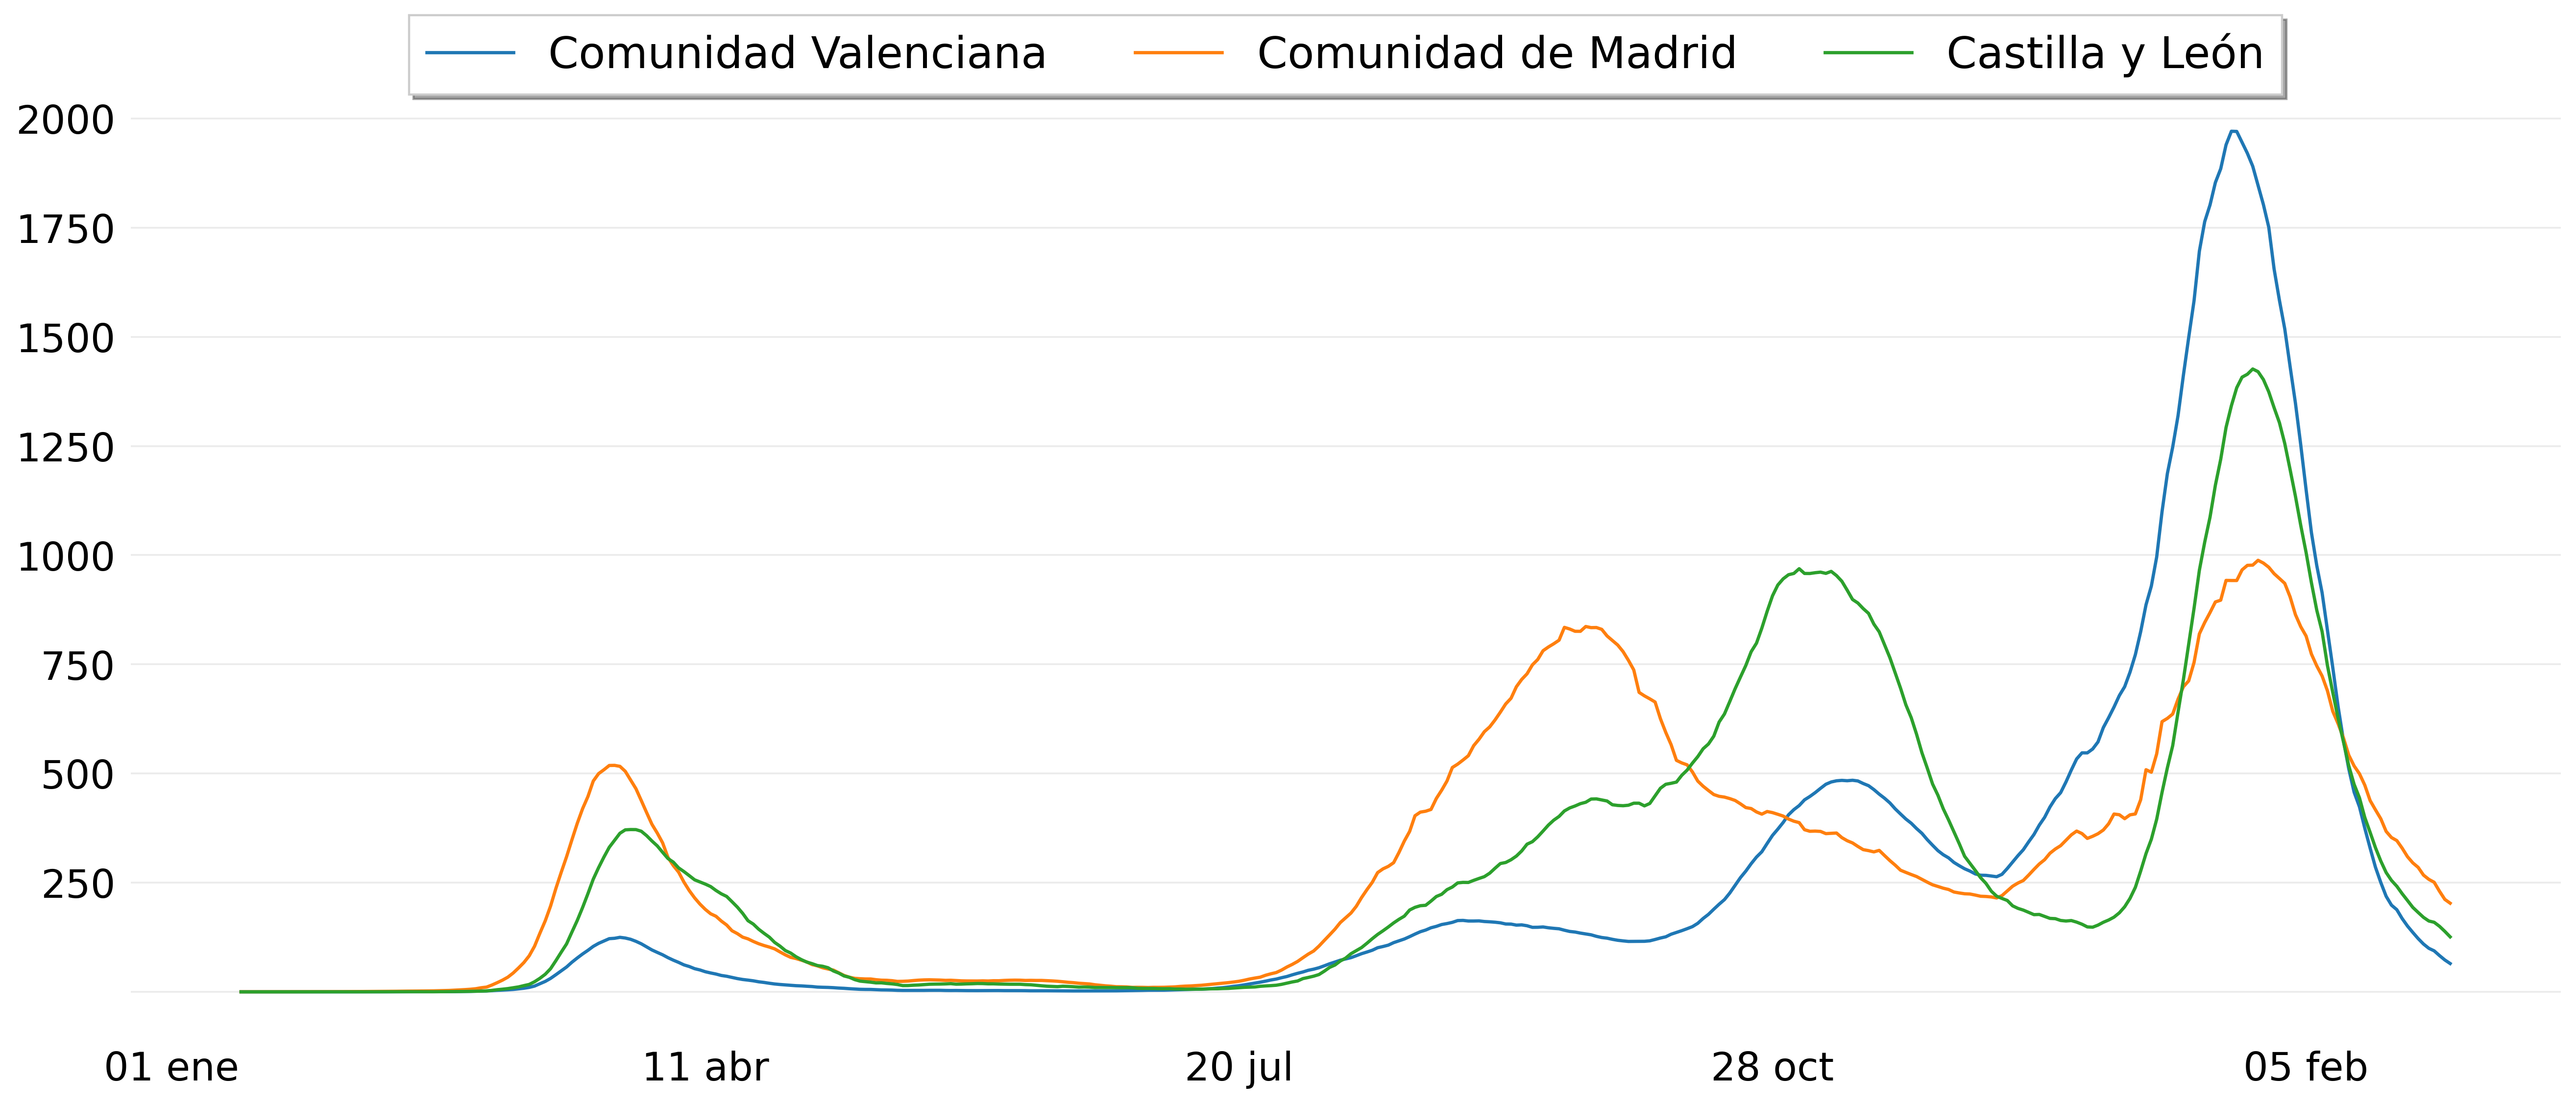

In [9]:
series.append('Castilla y León')

fig, ax = plt.subplots(figsize=(20,8)
                       , dpi = 320)

for i in series:
    df2[:-1][i].plot()

nice_axes(ax)
plt.show()